In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import helper_functions as hf
from scipy import signal

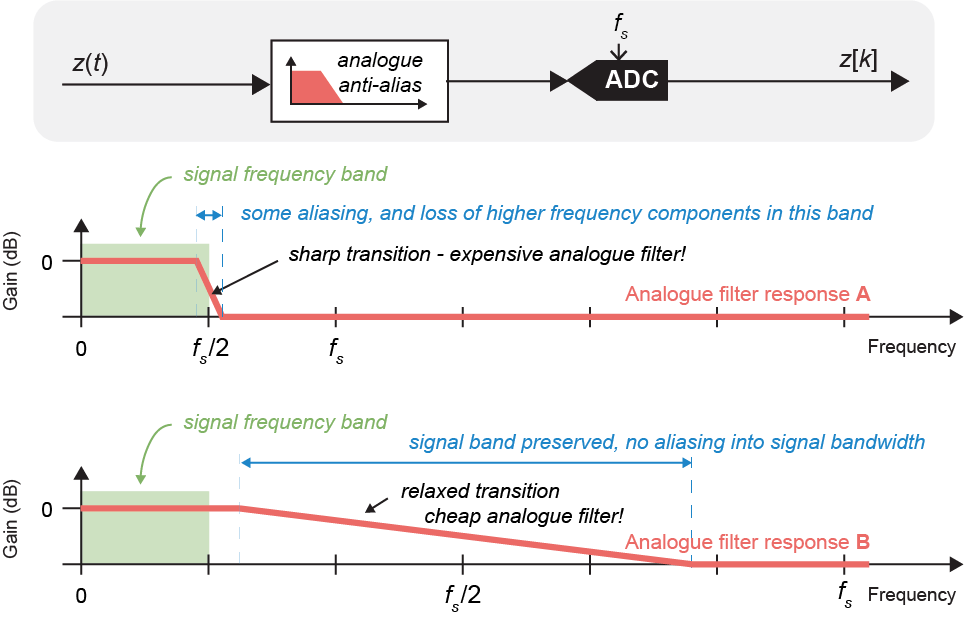

## 1. Aliasing

Consider a sine wave with frequency content as 50 Hz and 240 Hz and some noise contents

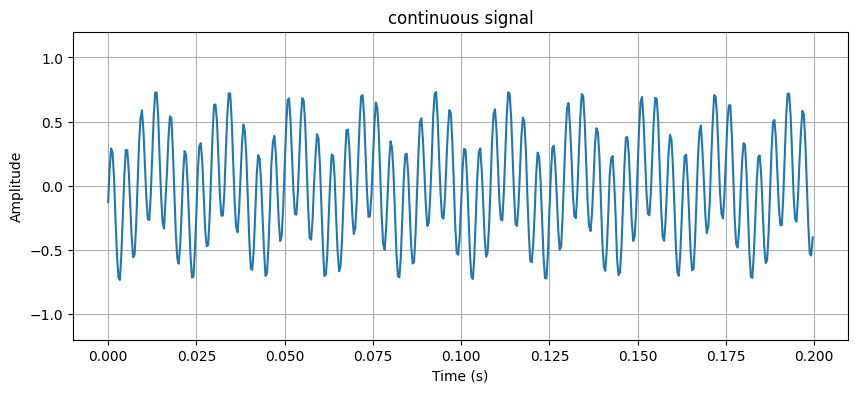

In [3]:
Aa = 0.25 # Amplitude a
Ab = 0.5  # Amplitude b

fa = 50     # desired frequency a
fb = 240    # desired frequency b

t = 0.2

fs_cont = 2400  #sampling frequency of the continuous waveform

#define continuous waveform for comparison
x_cont = np.arange(0, t, 1/fs_cont)
N_cont = np.size(x_cont)
noise = np.random.normal(0, 0.01, N_cont)
y_cont = Aa * np.sin(2*np.pi*fa*x_cont + 10) + Ab * np.sin(2*np.pi*fb*x_cont) + noise

# Plot the continuous signal
hf.plot_timeseries("continuous signal",
                   [x_cont],[y_cont],
                   ['continuous'])


Compute the log scale power of the continuous signal

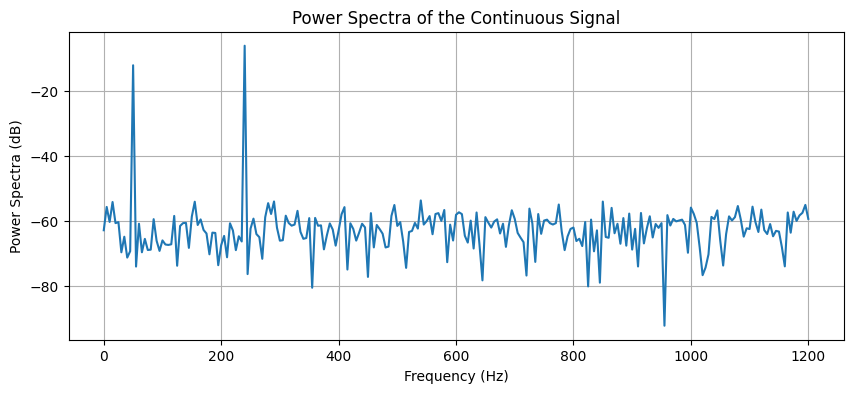

In [4]:
# Compute the log scale power of the continuous signal
Y_cont = np.fft.fft(y_cont)
Y_cont_norm = np.abs(Y_cont)*2/N_cont
Y_cont_log = 20*np.log10(Y_cont_norm)

# Plot the log scale power spectra
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(1, 1, 1)
axes.plot(np.arange(0, N_cont//2 + 1)*fs_cont/N_cont, Y_cont_log[0:N_cont//2+1])
axes.set_title('Power Spectra of the Continuous Signal')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Power Spectra (dB)')
axes.grid(True, 'Major')


We will sample the 'continuous' signal using a sampling frequency of 200Hz. According to Nyquist Sampling Theorem, all frequencies above half the sampling rate will alias

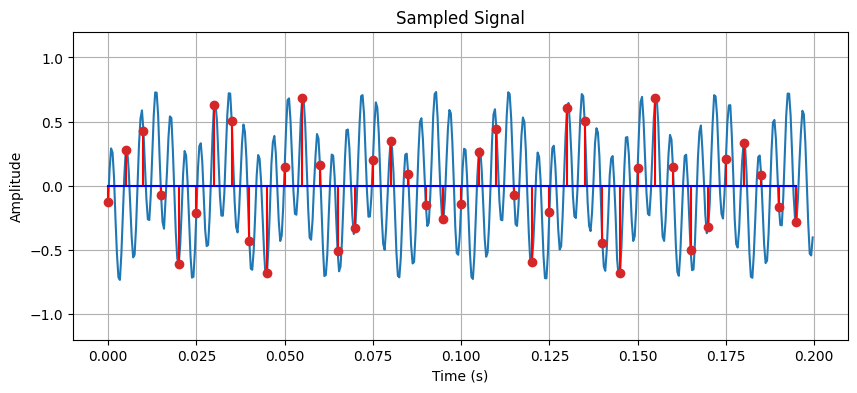

In [5]:
# Sampled signal
fs = 200
x = np.arange(0, t, 1/fs)   # Discrete time i.e. sampled time period
N = np.size(x)
y = y_cont[0::fs_cont//fs]  # Get sampled signal

# Plot the sampled signal
hf.plot_timeseries("Sampled Signal",
                   [x_cont, x], [y_cont, y], 
                   ['continuous','discrete'])

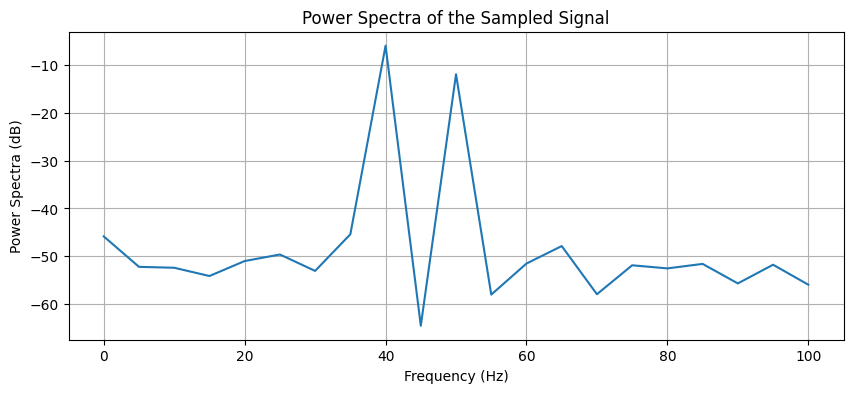

In [6]:
# Compute the sampled signal's log-scale power spectra
Y = np.fft.fft(y)
Y_norm = np.abs(Y)*2/N
Y_log = 20*np.log10(Y_norm)

# Plot the log-scale power spectra of the sampled signal
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(1, 1, 1)
axes.plot(np.arange(0, N//2+1)*fs/N, Y_log[0:N//2+1])
axes.set_title('Power Spectra of the Sampled Signal')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Power Spectra (dB)')
axes.grid(True, 'Major')

### 2. Anti-Aliasing Filter
An anti-alias filter is used before the 'continuous' signal is sampled by the ADC. The purpose of the filter is to suppress frequencies above the Nyquist Sampling rate.

In [7]:
# A simple function to generate a lowpass filter
def generate_lowpass(fs, cutoff, stop, numtaps):
    taps = signal.remez(numtaps, [0, cutoff, stop, 0.5*fs], [1, 0], fs=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

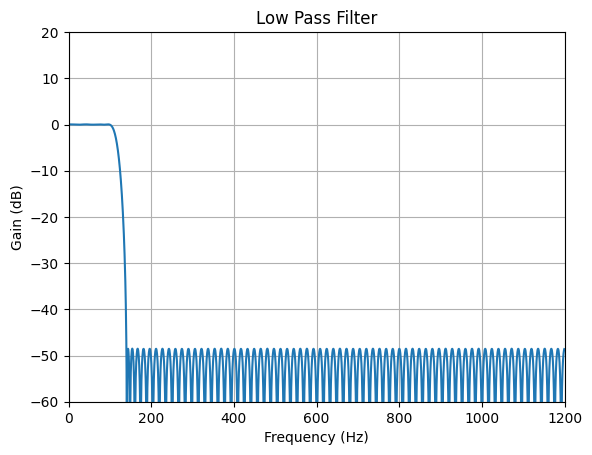

In [8]:
numtaps = 151
w, h, coeffs = generate_lowpass(fs_cont, fs/2, 1.4*(fs/2), numtaps)
hf.plot_response(fs_cont, w, h, title="Low Pass Filter")

The low pass filter is convolved with the sontinuous signal

In [9]:
# Filter the 'continuous' signal
y_cont_anti = signal.filtfilt(coeffs, 1, y_cont)

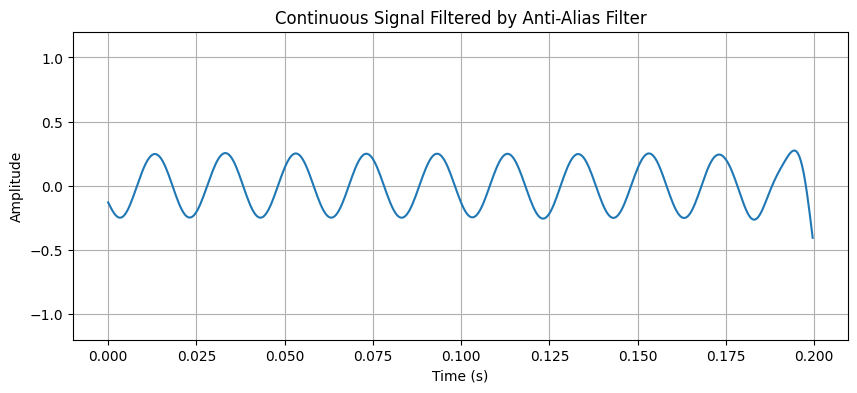

In [10]:
# Plot the 'continuous' signal filtered by the anti-alias filter
hf.plot_timeseries("Continuous Signal Filtered by Anti-Alias Filter",
                   [x_cont], [y_cont_anti],
                   ['continuous'])

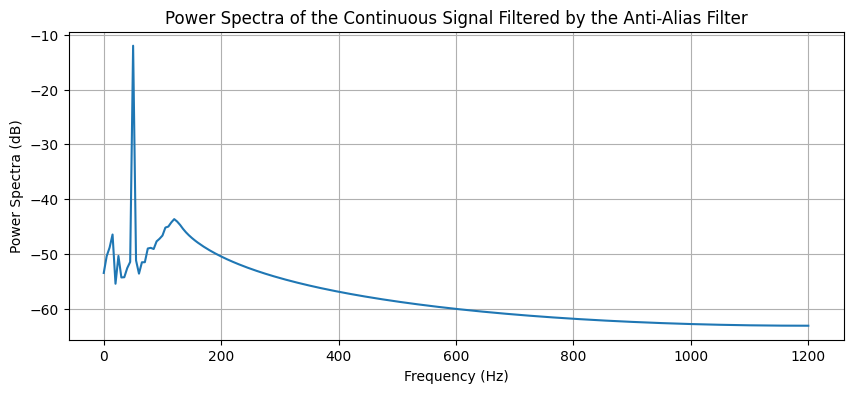

In [11]:
# Compute the log-scale power spectra of the anti-aliased signal
Y_cont_anti = np.fft.fft(y_cont_anti)
Y_cont_anti_norm = np.abs(Y_cont_anti)*2/N_cont
Y_cont_anti_log = 20*np.log10(Y_cont_anti_norm)

# Plot the log-scale power spectra of the anti-aliased signal
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(1, 1, 1)
axes.plot(np.arange(0, N_cont//2+1)*fs_cont/N_cont, Y_cont_anti_log[0:N_cont//2+1])
axes.set_title('Power Spectra of the Continuous Signal Filtered by the Anti-Alias Filter')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Power Spectra (dB)')
axes.grid(True, 'Major')

We can now sample the signal at 200Hz and plot the resulting log-scale power spectra below.

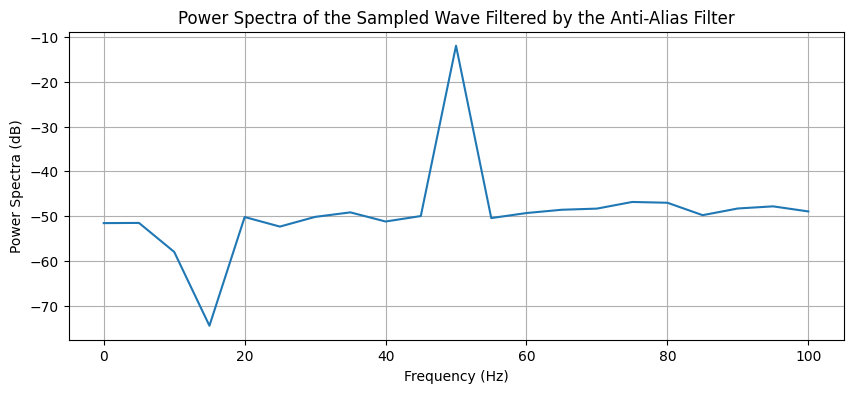

In [12]:
# Sample the continuous signal filtered by the anti-alias filter
y_anti = y_cont_anti[0::fs_cont//fs]

# Compute the log-scale power spectra of the sampled filtered signal
Y_anti = np.fft.fft(y_anti)
Y_anti_norm = np.abs(Y_anti)*2/N
Y_anti_log = 20*np.log10(Y_anti_norm)

# Plot the log-scale power spectra of the sampled filtered signal
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(1, 1, 1)
axes.plot(np.arange(0, N//2+1)*fs/N, Y_anti_log[0:N//2+1])
axes.set_title('Power Spectra of the Sampled Wave Filtered by the Anti-Alias Filter')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Power Spectra (dB)')
axes.grid(True, 'Major')

### 3. DAC - Digital to Analog Conversion

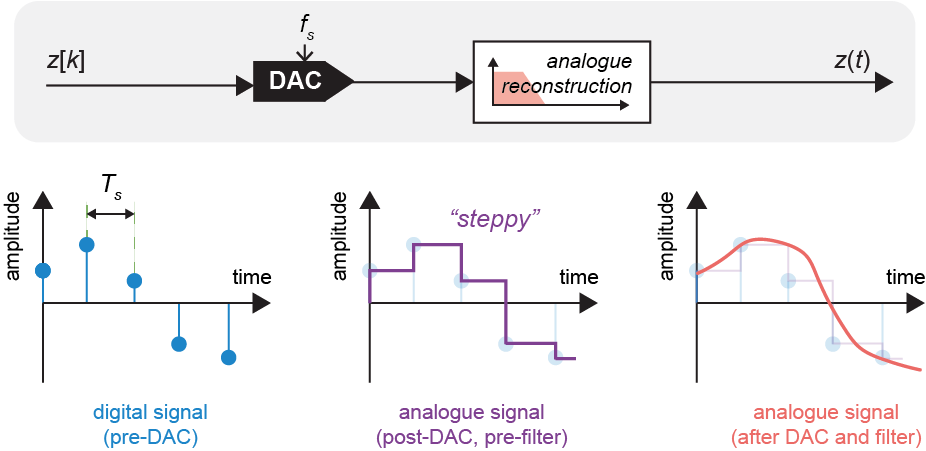

### 4. Zero Order Hold
The zero order hold function below first makes the signal "continuous" by zero padding the array to a rate of 48000 Hz - the rate we use to approximate an analogue signal in this notebook. This padded signal is then convolved with the impulse response of the ZOH, which is a rectangular window of length $t_s$

In [13]:
def zero_order_hold(signal, fs):
    # new time axis for the continuous signal
    x_zoh = np.arange(0, len(signal)/fs, 1/48000)

    # zero pad the original signal
    y_zoh = np.zeros(len(x_zoh))
    y_zoh_indices = y_zoh[::int(np.round(48000/fs))]
    y_zoh_indices[0:len(signal)] = signal
    y_zoh[::int(np.round(48000/fs))] = y_zoh_indices


    # Create zero order impulse response
    h_zoh = np.ones(int(48000/fs))
    y_zoh = np.convolve(h_zoh, y_zoh)

    y_zoh = y_zoh[0:len(x_zoh)]

    return x_zoh, y_zoh

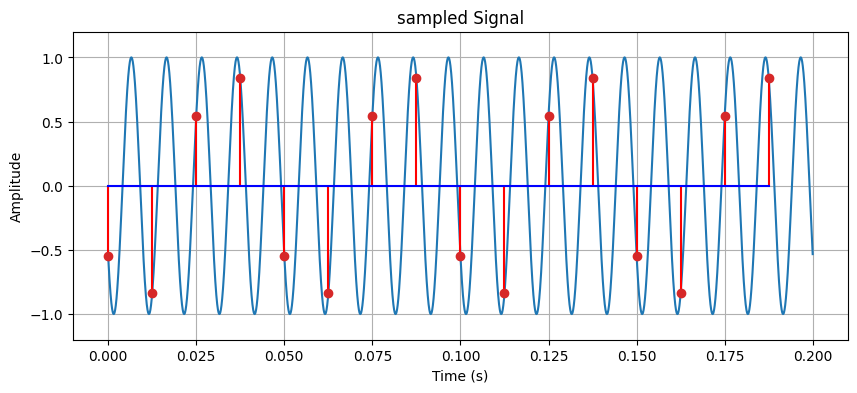

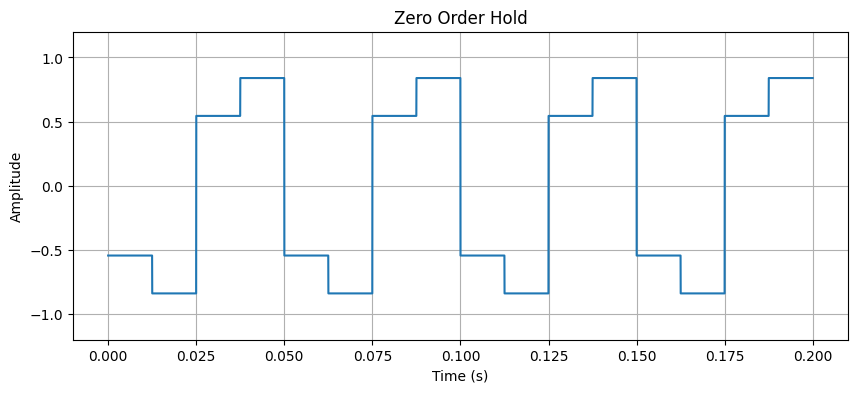

In [14]:
A = 1   # Amplitude
f = 100
t = 0.2
fs = 80


# continuous signal
x_cont = np.arange(0, t, 1/48000)
y_cont = A * np.sin(2*np.pi*f*x_cont + 10)

# sampled signal
x = np.arange(0, t, 1/fs)
y = A * np.sin(2 * np.pi * f * x + 10)

hf.plot_timeseries("sampled Signal",
                   [x_cont, x], [y_cont, y],
                   ['continuous', 'discrete'])

[x_zoh , y_zoh] = zero_order_hold(y, fs)

hf.plot_timeseries("Zero Order Hold",
                   [x_zoh], [y_zoh],
                   ['continuous'])
